### Testing pre-training models

In [53]:
import os
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms
from modular_classification import (data_setup, 
                                    engine)
import torchinfo

In [54]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [55]:
test_dir= "./datasets/pizza_sushi/test"
train_dir = "./datasets/pizza_sushi/train"

The model in this case have the specific values of: \
[Taken for the efficientnet_b0](https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b0.html)

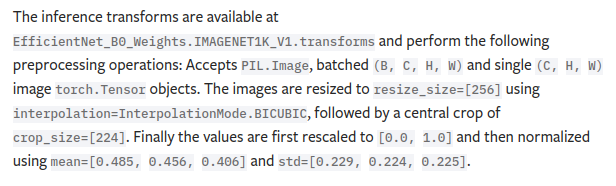

So we implement a transform to get those values. \
*Keep in mind that we don't actually need the mean and std values because the model can infeer those values*

In [56]:
model_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.255])
])

In [57]:
train_dataloader, test_dataloader,class_names = data_setup.create_dataloaders(train_dir=train_dir
                                                                               , test_dir=test_dir
                                                                                ,transform=model_transforms,
                                                                                  batch_size=32)
train_dataloader.dataset, test_dataloader.dataset

(Dataset ImageFolder
     Number of datapoints: 450
     Root location: ./datasets/pizza_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.255])
            ),
 Dataset ImageFolder
     Number of datapoints: 150
     Root location: ./datasets/pizza_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.255])
            ))

Lest see how the transformation affects the images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4285715].


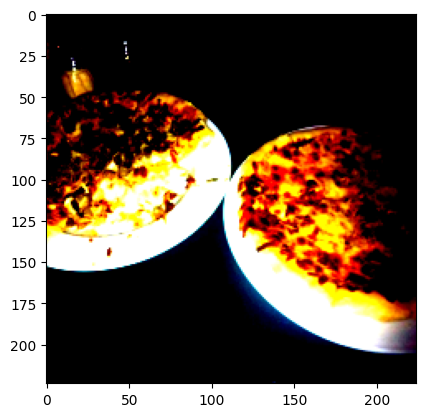

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9481792..2.4285715].


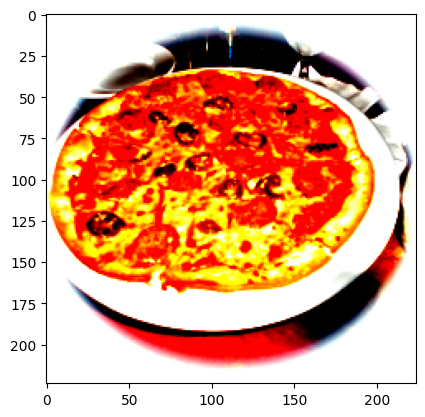

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0182073..2.4285715].


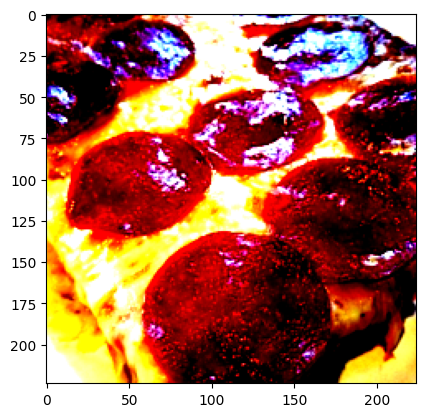

In [58]:
for i in range(3):
    img = next(iter(train_dataloader))[0][i]
    plt.imshow(img.permute(1, 2, 0))
    plt.show()

Lest see the max and min value in one image

In [59]:
print(torch.max(img[0]),torch.min(img[0]))

tensor(2.2489) tensor(-1.5699)


#### Loading the pre trained model

In [60]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

Lets see the transformation for the model

In [61]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

Pretty similar for that the one the we create earlier, we can use it an get the same results as this

In [62]:
train_dataloader_auto, test_dataloader_auto, class_names = data_setup.create_dataloaders(train_dir
                                                                               , test_dir
                                                                                ,auto_transforms,
                                                                                  32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4285715].


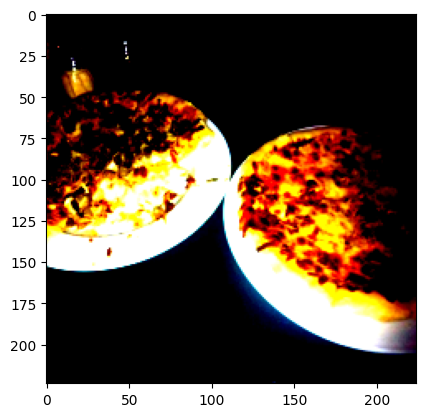

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9481792..2.4285715].


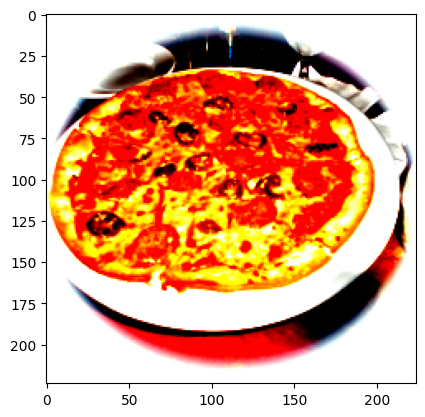

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0182073..2.4285715].


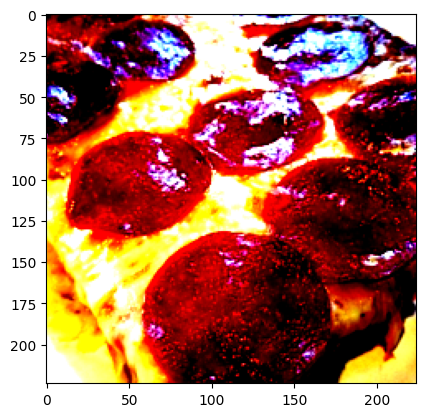

In [63]:
for i in range(3):
    img = next(iter(train_dataloader))[0][i]
    plt.imshow(img.permute(1, 2, 0))
    plt.show()

We get the same results, the difference of the two aproches is the lack of customization in using the auto transform

For more information of the model we can see the original paper found in [link](https://arxiv.org/abs/1905.11946)

In [64]:
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
torchinfo.summary(model,(32, 3, 224, 224), col_names=["num_params","trainable"]
                  ,row_settings=["var_names"])

Layer (type (var_name))                                      Param #                   Trainable
EfficientNet (EfficientNet)                                  --                        True
├─Sequential (features)                                      --                        True
│    └─Conv2dNormActivation (0)                              --                        True
│    │    └─Conv2d (0)                                       864                       True
│    │    └─BatchNorm2d (1)                                  64                        True
│    │    └─SiLU (2)                                         --                        --
│    └─Sequential (1)                                        --                        True
│    │    └─MBConv (0)                                       1,448                     True
│    └─Sequential (2)                                        --                        True
│    │    └─MBConv (0)                                       6,004           

5 million parameters and we can't see all the layers

Lets freeze the layers so the model doesn't changes its parameters when training, to do that we can put the requieres grad in false, so in the back propagation process it doest affect its features 2\
And then we do something about the classifier, because we don't need 1000 clases, we only have 3

In [65]:
for param in model.features.parameters():
    param.requires_grad = False

Lets see if it works

In [66]:
torchinfo.summary(model,(32, 3, 224, 224), col_names=["num_params","trainable"],row_settings=["var_names"])

Layer (type (var_name))                                      Param #                   Trainable
EfficientNet (EfficientNet)                                  --                        Partial
├─Sequential (features)                                      --                        False
│    └─Conv2dNormActivation (0)                              --                        False
│    │    └─Conv2d (0)                                       (864)                     False
│    │    └─BatchNorm2d (1)                                  (64)                      False
│    │    └─SiLU (2)                                         --                        --
│    └─Sequential (1)                                        --                        False
│    │    └─MBConv (0)                                       (1,448)                   False
│    └─Sequential (2)                                        --                        False
│    │    └─MBConv (0)                                       (6,004

In [67]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Ok, but the [out_features] is still in 1000

In [68]:
torch.manual_seed(23)
torch.cuda.manual_seed(23)

output_shape = len(class_names)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), #We dont change this variable
    torch.nn.Linear(in_features=1280, out_features=output_shape, bias=True)
).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

So remember the only trainable layers are the classifier layers lets see it 

In [69]:
torchinfo.summary(model,(32, 3, 224, 224), col_names=["num_params","trainable"]
                  ,row_settings=["var_names"])

Layer (type (var_name))                                      Param #                   Trainable
EfficientNet (EfficientNet)                                  --                        Partial
├─Sequential (features)                                      --                        False
│    └─Conv2dNormActivation (0)                              --                        False
│    │    └─Conv2d (0)                                       (864)                     False
│    │    └─BatchNorm2d (1)                                  (64)                      False
│    │    └─SiLU (2)                                         --                        --
│    └─Sequential (1)                                        --                        False
│    │    └─MBConv (0)                                       (1,448)                   False
│    └─Sequential (2)                                        --                        False
│    │    └─MBConv (0)                                       (6,004

So we only has 3,843 trainable parameters for this model

In [70]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [71]:
torch.manual_seed(23)
torch.cuda.manual_seed(23)

results = engine.train(model, test_dataloader, train_dataloader, loss_fn, optimizer, device, 10)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 |train_loss : 1.3170 |train_acc : 0.3104 |test_loss : 0.7334 |test_acc : 0.6403 
Epoch 2 |train_loss : 0.4716 |train_acc : 0.9187 |test_loss : 0.3733 |test_acc : 0.9563 
Epoch 3 |train_loss : 0.3874 |train_acc : 0.9146 |test_loss : 0.2704 |test_acc : 0.9812 
Epoch 4 |train_loss : 0.3050 |train_acc : 0.9292 |test_loss : 0.2234 |test_acc : 0.9875 
Epoch 5 |train_loss : 0.2459 |train_acc : 0.9417 |test_loss : 0.1957 |test_acc : 0.9812 
Epoch 6 |train_loss : 0.2088 |train_acc : 0.9563 |test_loss : 0.1748 |test_acc : 0.9812 
Epoch 7 |train_loss : 0.1833 |train_acc : 0.9625 |test_loss : 0.1588 |test_acc : 0.9812 
Epoch 8 |train_loss : 0.1633 |train_acc : 0.9688 |test_loss : 0.1463 |test_acc : 0.9812 
Epoch 9 |train_loss : 0.1469 |train_acc : 0.9688 |test_loss : 0.1365 |test_acc : 0.9812 
Epoch 10 |train_loss : 0.1331 |train_acc : 0.9688 |test_loss : 0.1285 |test_acc : 0.9812 


In [72]:
def plot_loss_curves(results: dict[str, list[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

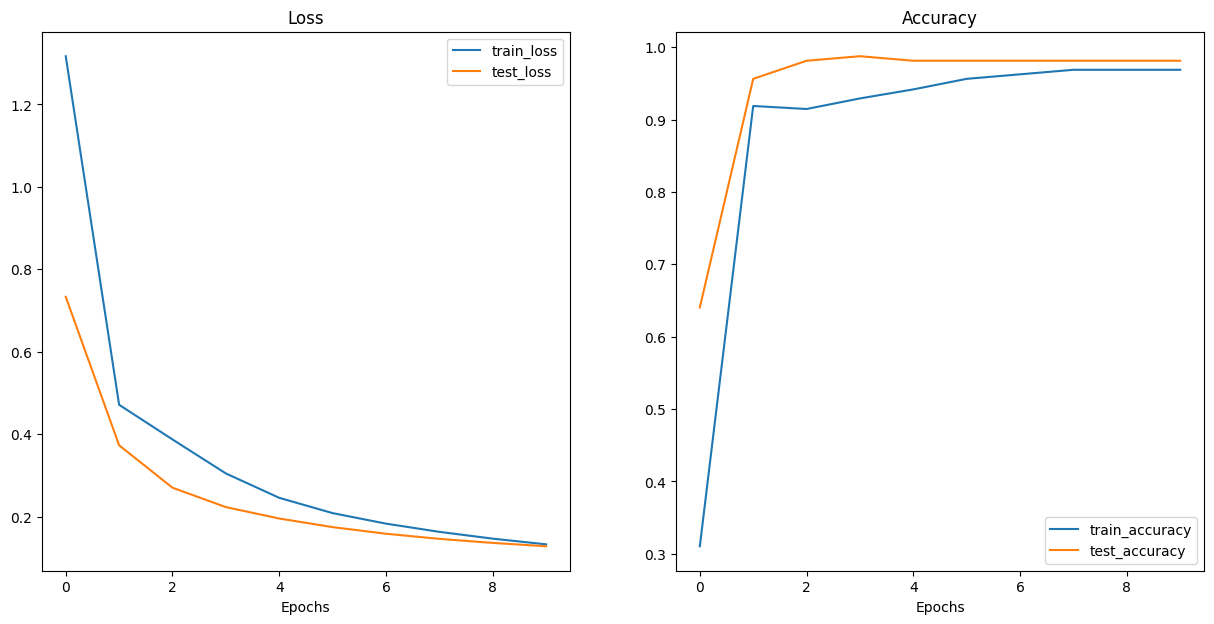

In [73]:
plot_loss_curves(results)

Lets see the confusion matrix

In [74]:
with torch.inference_mode():
    y_true = []
    y_logits_list = []
    samples = []
    for _, (x, y) in enumerate(test_dataloader):
        samples.append(x)
        y_true.append(y.to(device))
        y_logits = model(x.to(device))
        y_logits_list.append(y_logits)

In [75]:
y_true = torch.cat(y_true)
y_logits_list = torch.cat(y_logits_list)
samples = torch.cat(samples)

In [76]:
y_pred_list = torch.softmax(y_logits_list, 1).argmax(1)
y_pred_list

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2], device='cuda:0')

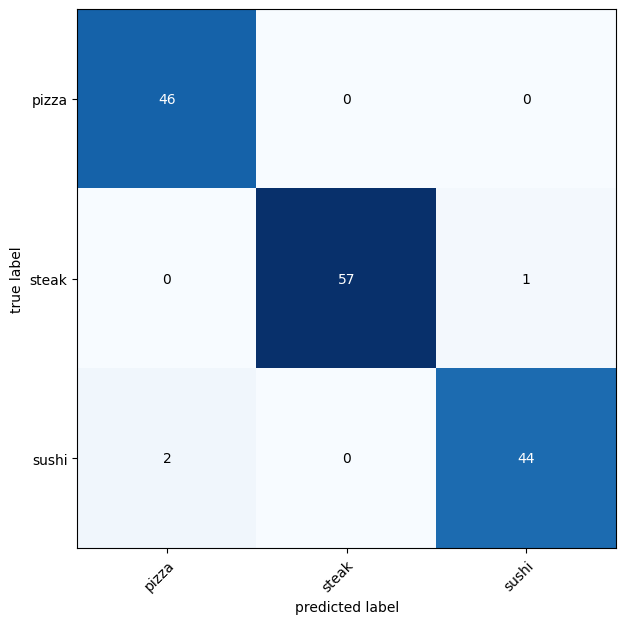

In [77]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_list.to("cpu"),
                         target=y_true.to("cpu"))

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

Lets see what are the most difficult images for this model

In [78]:
import pandas as pd
data = {"sample": [i for i in range(len(samples))], "label": y_true.cpu()
        , "prediction": y_pred_list.cpu(),
        "pred_prob": [row for row in torch.softmax(y_logits_list.cpu(), 1).numpy()]}
df = pd.DataFrame(data)
df.head(10)

,sample,label,prediction,pred_prob
0,0,0,0,"[0.9938285, 0.0033648622, 0.002806659]"
1,1,0,0,"[0.8964424, 0.039037656, 0.06451993]"
2,2,0,0,"[0.9982917, 0.0005726908, 0.0011357217]"
3,3,0,0,"[0.908506, 0.05600369, 0.035490353]"
4,4,0,0,"[0.9839954, 0.0066799778, 0.009324582]"
5,5,0,0,"[0.8403369, 0.10597754, 0.05368549]"
6,6,0,0,"[0.99146676, 0.0028885098, 0.0056447345]"
7,7,0,0,"[0.99539125, 0.0023733177, 0.0022354873]"
8,8,0,0,"[0.91185683, 0.045684285, 0.042458776]"
9,9,0,0,"[0.98318106, 0.007943532, 0.008875365]"


In [79]:
df = df[df["prediction"] != df["label"]]
df

,sample,label,prediction,pred_prob
85,85,1,2,"[0.027243964, 0.2247973, 0.74795866]"
114,114,2,0,"[0.52613217, 0.07758445, 0.39628333]"
127,127,2,0,"[0.82585216, 0.013543928, 0.16060387]"


In [80]:
def diff_label(row):
    return row["pred_prob"][row["label"]] - row["pred_prob"][row["prediction"]]

In [81]:
df["pred_diference"] = df.apply(diff_label, axis=1)
df

,sample,label,prediction,pred_prob,pred_diference
85,85,1,2,"[0.027243964, 0.2247973, 0.74795866]",-0.523161
114,114,2,0,"[0.52613217, 0.07758445, 0.39628333]",-0.129849
127,127,2,0,"[0.82585216, 0.013543928, 0.16060387]",-0.665248


In [82]:
df = df.sort_values(by="pred_diference", ascending=True)
df.head(5)

,sample,label,prediction,pred_prob,pred_diference
127,127,2,0,"[0.82585216, 0.013543928, 0.16060387]",-0.665248
85,85,1,2,"[0.027243964, 0.2247973, 0.74795866]",-0.523161
114,114,2,0,"[0.52613217, 0.07758445, 0.39628333]",-0.129849


In [83]:
class_names

['pizza', 'steak', 'sushi']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.4285715].


------------------
The model predicts is a pizza with a  82.5852 of probality


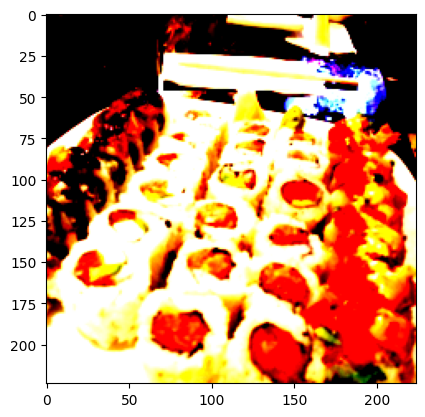

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.843908..2.4285715].


------------------
The model predicts is a sushi with a  74.7959 of probality


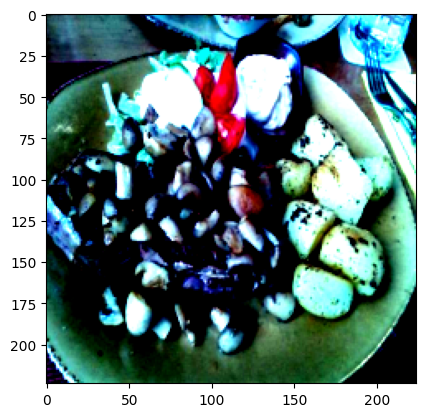

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4285715].


------------------
The model predicts is a pizza with a  52.6132 of probality


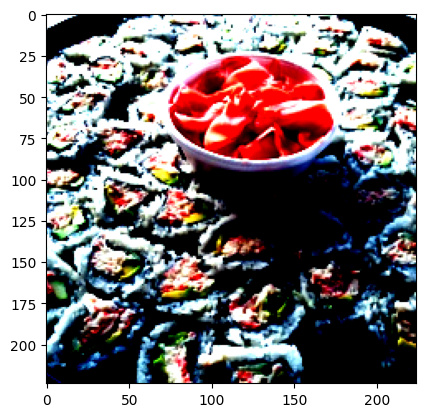

In [84]:
for i in df.index.values[:5]:
    print("------------------")
    predicted_class = df.loc[i, "prediction"]
    print(f"The model predicts is a {class_names[predicted_class]} with a {df.loc[i, "pred_prob"][predicted_class] * 100: .4f} of probality")
    plt.imshow(samples[i].permute(1, 2, 0))
    plt.show()

Only 3 wrong predictions with this model? can we do ir better?

### Using a more robust version of efficientnet

In [85]:
weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

Lets try the auto_transforms

In [86]:
train_dataloader, test_dataloader,class_names = data_setup.create_dataloaders(train_dir=train_dir
                                                                               , test_dir=test_dir
                                                                                ,transform=model_transforms,
                                                                                  batch_size=32)
train_dataloader.dataset, test_dataloader.dataset

(Dataset ImageFolder
     Number of datapoints: 450
     Root location: ./datasets/pizza_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.255])
            ),
 Dataset ImageFolder
     Number of datapoints: 150
     Root location: ./datasets/pizza_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.255])
            ))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4285715].


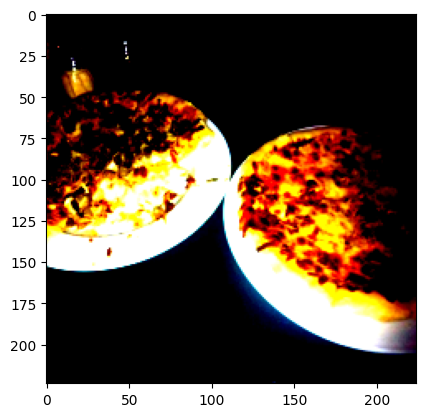

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9481792..2.4285715].


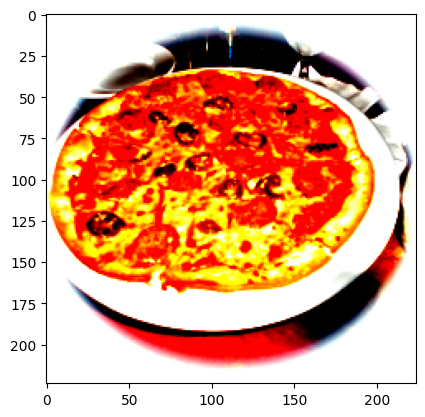

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0182073..2.4285715].


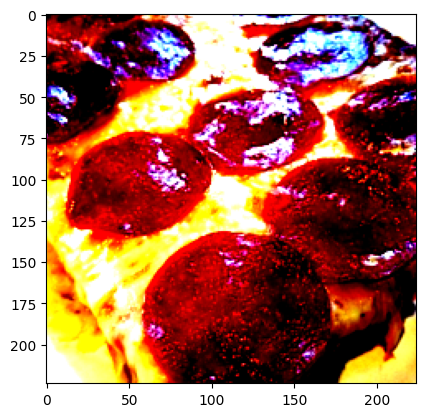

In [87]:
for i in range(3):
    img = next(iter(train_dataloader))[0][i]
    plt.imshow(img.permute(1, 2, 0))
    plt.show()

In [88]:
model = torchvision.models.efficientnet_b2(weights=weights).to(device)
torchinfo.summary(model,(32, 3, 224, 224), col_names=["num_params","trainable"]
                  ,row_settings=["var_names"])

Layer (type (var_name))                                      Param #                   Trainable
EfficientNet (EfficientNet)                                  --                        True
├─Sequential (features)                                      --                        True
│    └─Conv2dNormActivation (0)                              --                        True
│    │    └─Conv2d (0)                                       864                       True
│    │    └─BatchNorm2d (1)                                  64                        True
│    │    └─SiLU (2)                                         --                        --
│    └─Sequential (1)                                        --                        True
│    │    └─MBConv (0)                                       1,448                     True
│    │    └─MBConv (1)                                       612                       True
│    └─Sequential (2)                                        --              

Well 9 million parameters, i hope the model at least need less epochs to train

In [89]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [90]:
for param in model.features.parameters():
    param.requires_grad = False

torch.manual_seed(23)
torch.cuda.manual_seed(23)

output_shape = len(class_names)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.3, inplace=True), #We dont change this variable
    torch.nn.Linear(in_features=1408, out_features=output_shape, bias=True)
).to(device)

In [91]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [92]:
torchinfo.summary(model,(32, 3, 224, 224), col_names=["num_params","trainable"]
                  ,row_settings=["var_names"])

Layer (type (var_name))                                      Param #                   Trainable
EfficientNet (EfficientNet)                                  --                        Partial
├─Sequential (features)                                      --                        False
│    └─Conv2dNormActivation (0)                              --                        False
│    │    └─Conv2d (0)                                       (864)                     False
│    │    └─BatchNorm2d (1)                                  (64)                      False
│    │    └─SiLU (2)                                         --                        --
│    └─Sequential (1)                                        --                        False
│    │    └─MBConv (0)                                       (1,448)                   False
│    │    └─MBConv (1)                                       (612)                     False
│    └─Sequential (2)                                        --    

So we got 4,227 params to train

In [93]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

torch.manual_seed(23)
torch.cuda.manual_seed(23)

results2 = engine.train(model, test_dataloader, train_dataloader, loss_fn, optimizer, device, 10)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 |train_loss : 1.0915 |train_acc : 0.3896 |test_loss : 0.6468 |test_acc : 0.7051 
Epoch 2 |train_loss : 0.4277 |train_acc : 0.9417 |test_loss : 0.3563 |test_acc : 0.9659 
Epoch 3 |train_loss : 0.3094 |train_acc : 0.9375 |test_loss : 0.2612 |test_acc : 0.9534 
Epoch 4 |train_loss : 0.2554 |train_acc : 0.9437 |test_loss : 0.2156 |test_acc : 0.9659 
Epoch 5 |train_loss : 0.2158 |train_acc : 0.9500 |test_loss : 0.1897 |test_acc : 0.9597 
Epoch 6 |train_loss : 0.1877 |train_acc : 0.9583 |test_loss : 0.1719 |test_acc : 0.9597 
Epoch 7 |train_loss : 0.1669 |train_acc : 0.9646 |test_loss : 0.1586 |test_acc : 0.9597 
Epoch 8 |train_loss : 0.1506 |train_acc : 0.9708 |test_loss : 0.1482 |test_acc : 0.9659 
Epoch 9 |train_loss : 0.1372 |train_acc : 0.9729 |test_loss : 0.1399 |test_acc : 0.9722 
Epoch 10 |train_loss : 0.1257 |train_acc : 0.9771 |test_loss : 0.1330 |test_acc : 0.9722 


It got worst? wow, but the cross validation results its a little better, at more computing time cost, 41.4 seg compared with 36 of the previous mode

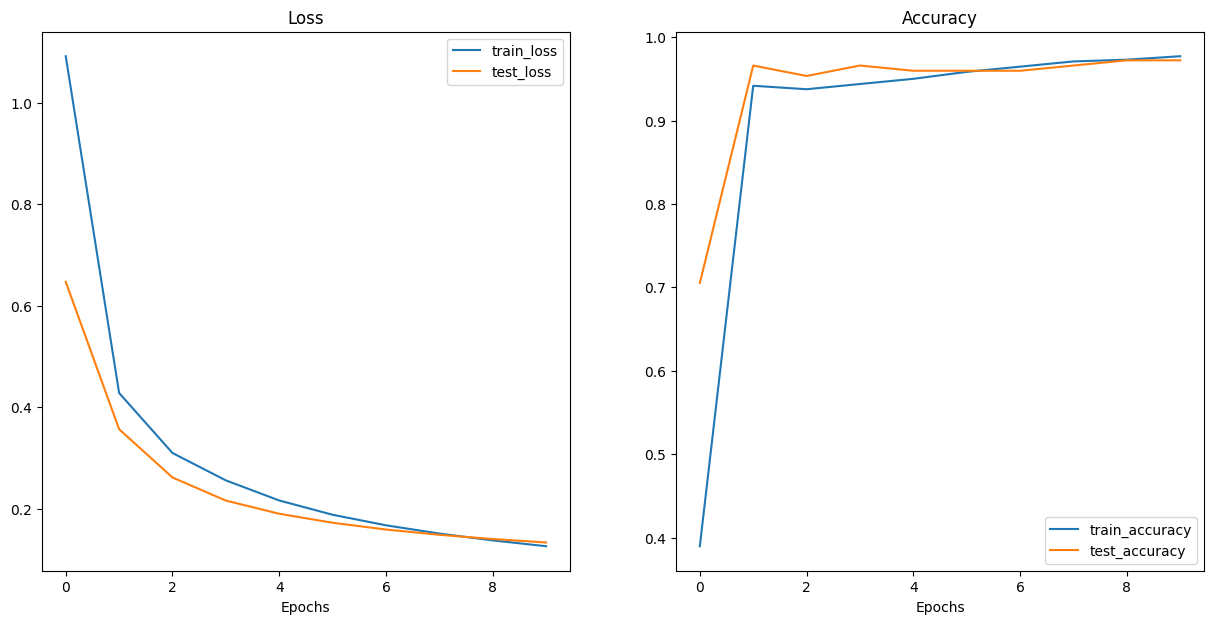

In [94]:
plot_loss_curves(results2)

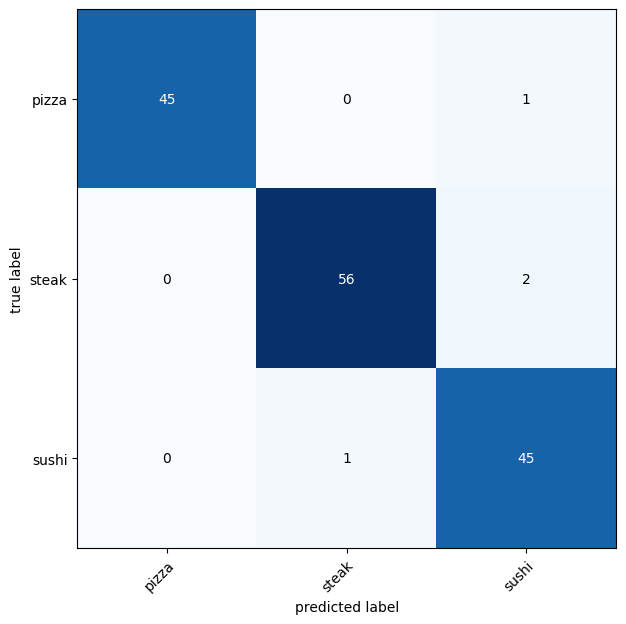

In [95]:
with torch.inference_mode():
    y_true = []
    y_logits_list = []
    samples = []
    for _, (x, y) in enumerate(test_dataloader):
        samples.append(x)
        y_true.append(y.to(device))
        y_logits = model(x.to(device))
        y_logits_list.append(y_logits)

y_true = torch.cat(y_true)
y_logits_list = torch.cat(y_logits_list)
samples = torch.cat(samples)
y_pred_list = torch.softmax(y_logits_list, 1).argmax(1)

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_list.to("cpu"),
                         target=y_true.to("cpu"))

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

And it gets more labels wrong, so simplicity is the best in this simple cases huh

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.843908..2.4285715].


------------------
The model predicts is a sushi with a  77.1249 of probality


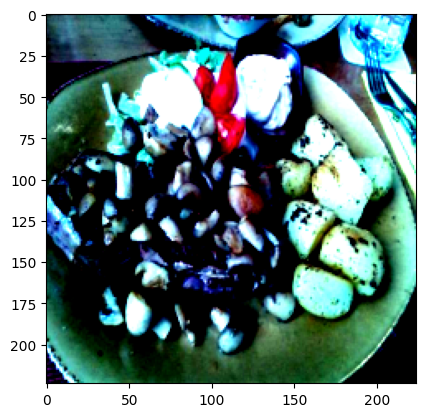

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.4285715].


------------------
The model predicts is a sushi with a  69.5242 of probality


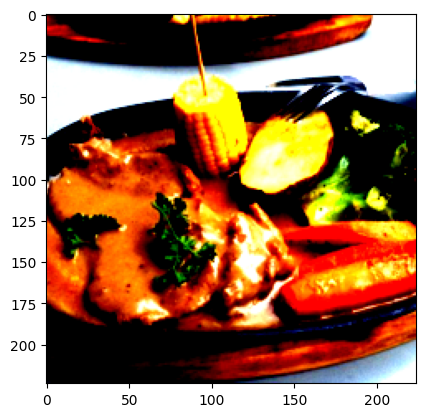

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4285715].


------------------
The model predicts is a sushi with a  48.7397 of probality


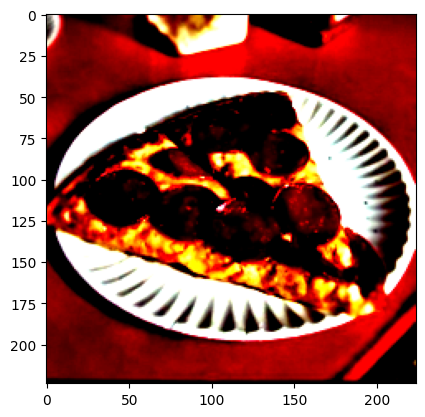

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3760502].


------------------
The model predicts is a steak with a  47.2310 of probality


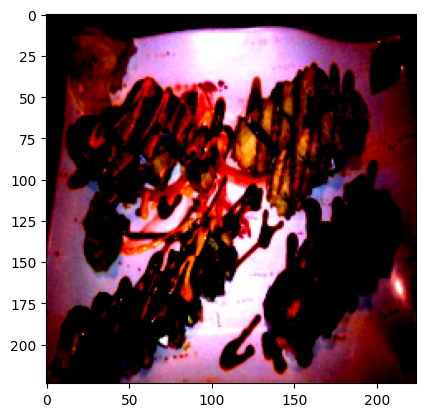

In [96]:
data = {"sample": [i for i in range(len(samples))], "label": y_true.cpu()
        , "prediction": y_pred_list.cpu(),
        "pred_prob": [row for row in torch.softmax(y_logits_list.cpu(), 1).numpy()]}
df = pd.DataFrame(data)
df = df[df["prediction"] != df["label"]]
df["pred_diference"] = df.apply(diff_label, axis=1)
df = df.sort_values(by="pred_diference", ascending=True)
for i in df.index.values[:5]:
    print("------------------")
    predicted_class = df.loc[i, "prediction"]
    print(f"The model predicts is a {class_names[predicted_class]} with a {df.loc[i, "pred_prob"][predicted_class] * 100: .4f} of probality")
    plt.imshow(samples[i].permute(1, 2, 0))
    plt.show()

In [97]:
df2 = pd.DataFrame(results2)
df1 = pd.DataFrame(results)
(df2-df1).mean()

train_loss   -0.049416
train_acc     0.016667
test_loss    -0.011982
test_acc     -0.007330
dtype: float64

So the model 1 perform better over all the epochs, but in train accuracy is a little better at cost of a little more time of training

In [98]:
df2-df1

,train_loss,train_acc,test_loss,test_acc
0,-0.225432,0.079167,-0.086582,0.064773
1,-0.043823,0.022917,-0.016980,0.009659
2,-0.077997,0.022917,-0.009193,-0.027841
3,-0.049575,0.014583,-0.007742,-0.021591
4,-0.030026,0.008333,-0.006032,-0.021591
5,-0.021089,0.002083,-0.002870,-0.021591
6,-0.016391,0.002083,-0.000180,-0.021591
7,-0.012702,0.002083,0.001844,-0.015341
8,-0.009725,0.004167,0.003369,-0.009091
9,-0.007401,0.008333,0.004543,-0.009091


So the simpler model is better in this case